# Building a MLP inds

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from tqdm import tqdm

import sys
sys.path.append('../..')

from logger import setup_logging
from models import MLP
from utils import (
    dataset,
    test,
    train,
    train_copy,
    utils,
    visualisation
)

/home/yanh/ENTER/envs/env02/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
LOG_CONFIG_PATH = os.path.join(os.path.abspath("../.."), "logger", "logger_config.json")
LOG_DIR   = os.path.join(os.path.abspath("../.."), "logs")
DATA_DIR  = os.path.join(os.path.abspath("../.."), "data")
IMAGE_DIR = os.path.join(os.path.abspath("../.."), "images")

Check if GPU is active.

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [4]:
utils.mkdir(LOG_DIR)
setup_logging(save_dir=LOG_DIR, log_config=LOG_CONFIG_PATH)

### Create the DataLoader

In [5]:
# Get the datasets
train_data, val_data, test_data = dataset.get_dataset(data_path=DATA_DIR, balanced=True)#之前是False

# How many instances have we got?
print('# instances in training set: ', len(train_data))
print('# instances in validation set: ', len(val_data))
print('# instances in testing set: ', len(test_data))

batch_size = 64

# Create the dataloaders - for training, validation and testing
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# instances in training set:  140000
# instances in validation set:  485146
# instances in testing set:  485145


In [6]:
np.unique(train_data.labels)

array([0, 1, 2, 3, 4, 5, 6])

In [7]:
train_data.labels.to_numpy()

array([0, 0, 0, ..., 1, 1, 1])

### Instantiate the network, the loss function and the optimizer

In [8]:
from sklearn.utils.class_weight import compute_class_weight

class_weight = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.labels),#train_data.labels.label
    y=train_data.labels.to_numpy()
)
class_weight = torch.FloatTensor(class_weight)

In [9]:
# Creating a MLP
model = MLP(49, 64, 64, 7)#49, 64, 64, 6

# Out loss function
criterion = nn.CrossEntropyLoss(weight=class_weight)

# Our optimizer
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Epochs
num_epochs = 5

In [10]:
print(model)

MLP(
  (fc1): Linear(in_features=49, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=7, bias=True)
)


In [11]:
from tqdm import tqdm
import logging
def train1(
    model: torch.nn.Module,
    criterion: torch.nn.Module,
    optimizer: torch.optim,
    train_loader: torch.utils.data.DataLoader,
    valid_loader: torch.utils.data.DataLoader,
    num_epochs: int,
    device: torch.device,
):
    model.to(device)

    history = {
        'train': {
            'total': 0,
            'loss': [],
            'accuracy': [],
            'output_pred': [],
            'output_true': []
        },
        'valid': {
            'total': 0,
            'loss': [],
            'accuracy': [],
            'output_pred': [],
            'output_true': []
        }
    }

    for epoch in range(1, num_epochs+1):
        #训练过程
        model.train()

        train_loss = 0.0
        train_steps = 0
        train_total = 0
        train_correct = 0

        train_output_pred = []
        train_output_true = []

        logging.info(f"Epoch {epoch}/{num_epochs}:")
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            #labels = labels.squeeze(1)
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #train_loss += loss.cpu().item()
            train_loss += loss.item()
            train_steps += 1

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            #train_output_pred += outputs.argmax(1).cpu().tolist()
            train_output_pred += outputs.argmax(1).tolist()
            train_output_true += labels.tolist()
        #验证过程
        model.eval()

        val_loss = 0.0
        val_steps = 0
        val_total = 0
        val_correct = 0

        val_output_pred = []
        val_output_true = []

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                #labels = labels.squeeze(1)
                labels = labels.view(-1)
                outputs = model(inputs)

                loss = criterion(outputs, labels)
                val_loss += loss.numpy()
                val_steps += 1

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                val_output_pred += outputs.argmax(1).tolist()
                val_output_true += labels.tolist()
        history['train']['total'] = train_total
        history['train']['loss'].append(train_loss/train_steps)
        history['train']['accuracy'].append(train_correct/train_total)
        history['train']['output_pred'] = train_output_pred
        history['train']['output_true'] = train_output_true

        history['valid']['total'] = val_total
        history['valid']['loss'].append(val_loss/val_steps)
        history['valid']['accuracy'].append(val_correct/val_total)
        history['valid']['output_pred'] = val_output_pred
        history['valid']['output_true'] = val_output_true

        logging.info(f'loss: {train_loss/train_steps} - acc: {train_correct/train_total} - val_loss: {val_loss/val_steps} - val_acc: {val_correct/val_total}')

    logging.info(f"Finished Training")

    return history

### Train it

In [13]:
from utils import train_copy
#history = train_copy.train(model, criterion, optimizer, train_loader, valid_loader, num_epochs, device)
device = 'cpu'
history = train1(model, criterion, optimizer, train_loader, valid_loader, num_epochs, device)

training_loss = history['train']['loss']
training_accuracy = history['train']['accuracy']
train_output_true = history['train']['output_true']
train_output_pred = history['train']['output_pred']

validation_loss = history['valid']['loss']
validation_accuracy = history['valid']['accuracy']
valid_output_true = history['valid']['output_true']
valid_output_pred = history['valid']['output_pred']

INFO 2024-03-26 14:43:06,600 | <ipython-input-11-31c0bfc194df>:43 | Epoch 1/5:


  0%|          | 0/2188 [00:00<?, ?it/s]

100%|██████████| 2188/2188 [00:18<00:00, 120.46it/s]


INFO 2024-03-26 14:44:56,383 | <ipython-input-11-31c0bfc194df>:105 | loss: 0.18261440731121067 - acc: 0.9451285714285714 - val_loss: 0.21576731804256594 - val_acc: 0.9231653976328775
INFO 2024-03-26 14:44:56,385 | <ipython-input-11-31c0bfc194df>:43 | Epoch 2/5:


100%|██████████| 2188/2188 [00:18<00:00, 117.88it/s]


INFO 2024-03-26 14:46:46,669 | <ipython-input-11-31c0bfc194df>:105 | loss: 0.052677418732819004 - acc: 0.9867071428571429 - val_loss: 0.11363204880453555 - val_acc: 0.9576333722219703
INFO 2024-03-26 14:46:46,671 | <ipython-input-11-31c0bfc194df>:43 | Epoch 3/5:


100%|██████████| 2188/2188 [00:18<00:00, 119.52it/s]


INFO 2024-03-26 14:48:36,924 | <ipython-input-11-31c0bfc194df>:105 | loss: 0.04281469484763705 - acc: 0.9888857142857143 - val_loss: 0.13253343511490617 - val_acc: 0.9541808033045722
INFO 2024-03-26 14:48:36,926 | <ipython-input-11-31c0bfc194df>:43 | Epoch 4/5:


100%|██████████| 2188/2188 [00:17<00:00, 121.72it/s]


INFO 2024-03-26 14:50:26,415 | <ipython-input-11-31c0bfc194df>:105 | loss: 0.03771441085039556 - acc: 0.9900785714285715 - val_loss: 0.15713452411890894 - val_acc: 0.9572664723608976
INFO 2024-03-26 14:50:26,418 | <ipython-input-11-31c0bfc194df>:43 | Epoch 5/5:


100%|██████████| 2188/2188 [00:18<00:00, 119.69it/s]


INFO 2024-03-26 14:52:15,753 | <ipython-input-11-31c0bfc194df>:105 | loss: 0.034628425710252486 - acc: 0.9907928571428571 - val_loss: 0.09225784133610967 - val_acc: 0.9650167166172657
INFO 2024-03-26 14:52:15,755 | <ipython-input-11-31c0bfc194df>:107 | Finished Training


### Plot loss vs iterations

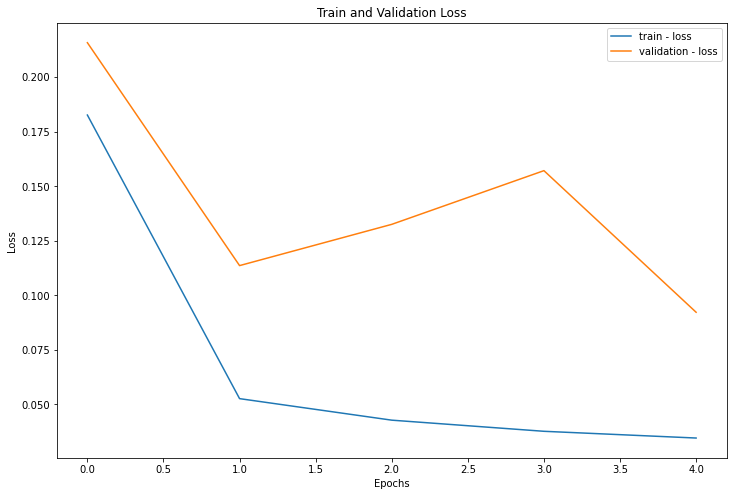

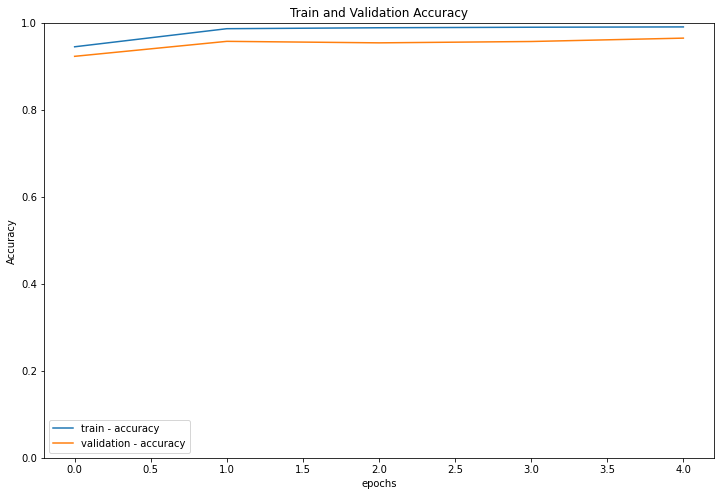

In [14]:
fig = plt.figure(figsize=(12, 8))
plt.plot(training_loss, label='train - loss')
plt.plot(validation_loss, label='validation - loss')
plt.title("Train and Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.show()

fig = plt.figure(figsize=(12, 8))
plt.plot(training_accuracy, label='train - accuracy')
plt.plot(validation_accuracy, label='validation - accuracy')
plt.title("Train and Validation Accuracy")
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend(loc="best")
plt.show()

### Plot confusion matrix

FileNotFoundError: [Errno 2] No such file or directory: '/home/yanh/coding/dbn-based-nids/images/imb_cw_dbn_train_confusion_matrix.pdf'

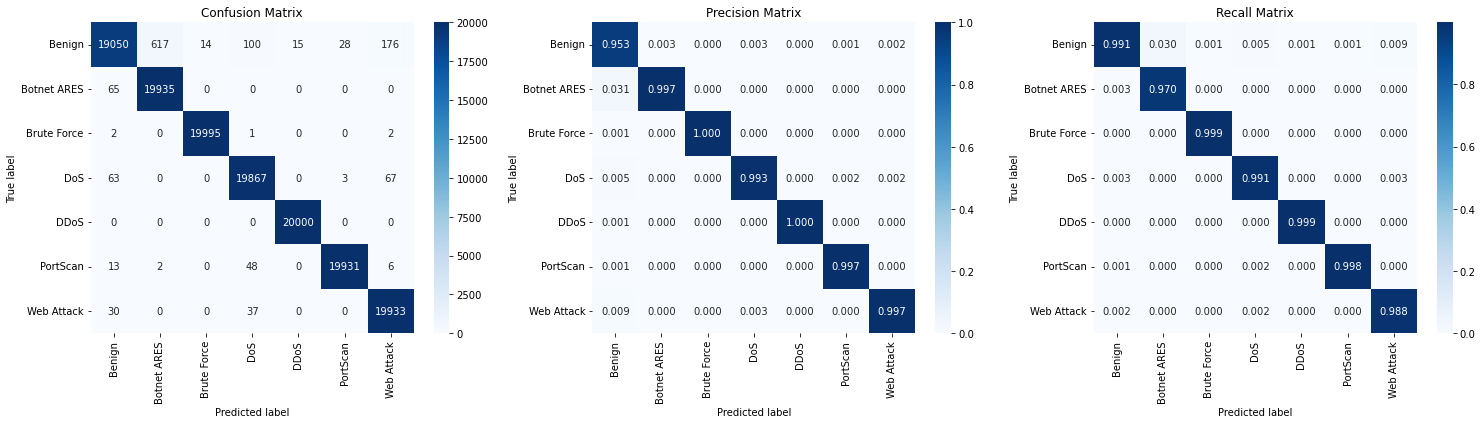

In [17]:
#labels = ['Benign', 'Botnet ARES', 'Brute Force', 'DoS/DDoS', 'PortScan', 'Web Attack']
labels = ['Benign', 'Botnet ARES', 'Brute Force', 'DoS', 'DDoS', 'PortScan', 'Web Attack']
visualisation.plot_confusion_matrix(y_true=train_output_true,
                                    y_pred=train_output_pred,
                                    labels=labels,
                                    save=True,
                                    save_dir=IMAGE_DIR,
                                    filename="imb_cw_dbn_train_confusion_matrix.pdf")

In [18]:
from sklearn.metrics import classification_report

print("Training Set -- Classification Report", end="\n\n")
print(classification_report(train_output_true, train_output_pred, target_names=labels))

Training Set -- Classification Report

              precision    recall  f1-score   support

      Benign       0.99      0.95      0.97     20000
 Botnet ARES       0.97      1.00      0.98     20000
 Brute Force       1.00      1.00      1.00     20000
         DoS       0.99      0.99      0.99     20000
        DDoS       1.00      1.00      1.00     20000
    PortScan       1.00      1.00      1.00     20000
  Web Attack       0.99      1.00      0.99     20000

    accuracy                           0.99    140000
   macro avg       0.99      0.99      0.99    140000
weighted avg       0.99      0.99      0.99    140000



FileNotFoundError: [Errno 2] No such file or directory: '/home/yanh/coding/dbn-based-nids/images/imb_cw_dbn_valid_confusion_matrix.pdf'

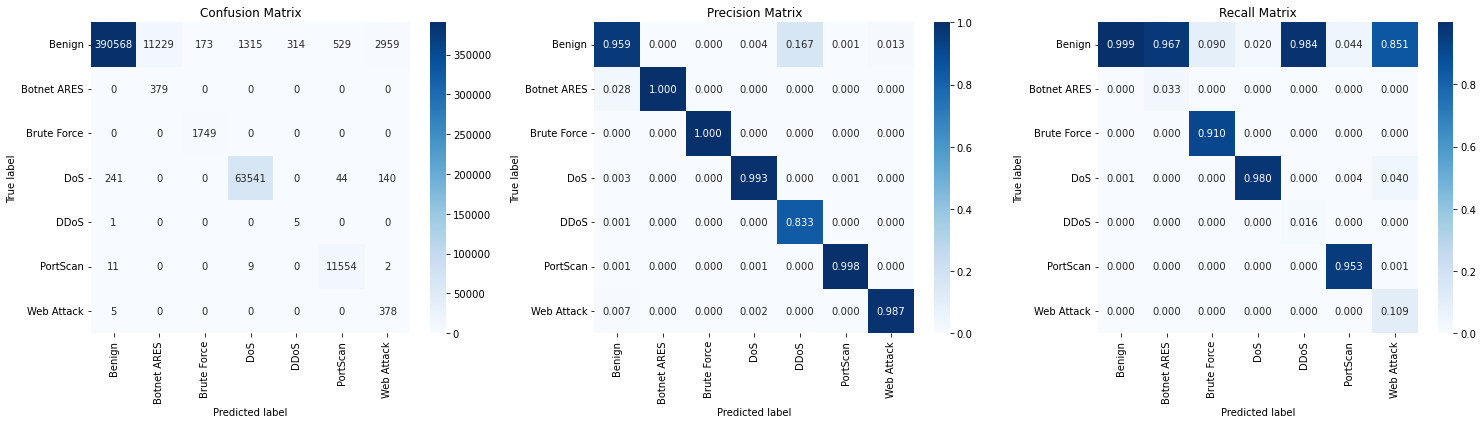

In [19]:
visualisation.plot_confusion_matrix(y_true=valid_output_true,
                                    y_pred=valid_output_pred,
                                    labels=labels,
                                    save=True,
                                    save_dir=IMAGE_DIR,
                                    filename="imb_cw_dbn_valid_confusion_matrix.pdf")

In [20]:
print("Validation Set -- Classification Report", end="\n\n")
print(classification_report(valid_output_true, valid_output_pred, target_names=labels))

Validation Set -- Classification Report

              precision    recall  f1-score   support

      Benign       1.00      0.96      0.98    407087
 Botnet ARES       0.03      1.00      0.06       379
 Brute Force       0.91      1.00      0.95      1749
         DoS       0.98      0.99      0.99     63966
        DDoS       0.02      0.83      0.03         6
    PortScan       0.95      1.00      0.97     11576
  Web Attack       0.11      0.99      0.20       383

    accuracy                           0.97    485146
   macro avg       0.57      0.97      0.60    485146
weighted avg       0.99      0.97      0.98    485146



### Test it

In [21]:
#################
### TEST LOOP ###
#################
history = test(model, criterion, test_loader, device)

test_output_true = history['test']['output_true']
test_output_pred = history['test']['output_pred']
test_output_pred_prob = history['test']['output_pred_prob']

100%|██████████| 7581/7581 [01:32<00:00, 81.71it/s]

INFO 2024-03-26 14:57:11,589 | test.py:82 | Test loss: 0.09253779876722569, Test accuracy: 0.9649238887342959


### Classification Report

FileNotFoundError: [Errno 2] No such file or directory: '/home/yanh/coding/dbn-based-nids/images/imb_cw_dbn_test_confusion_matrix.pdf'

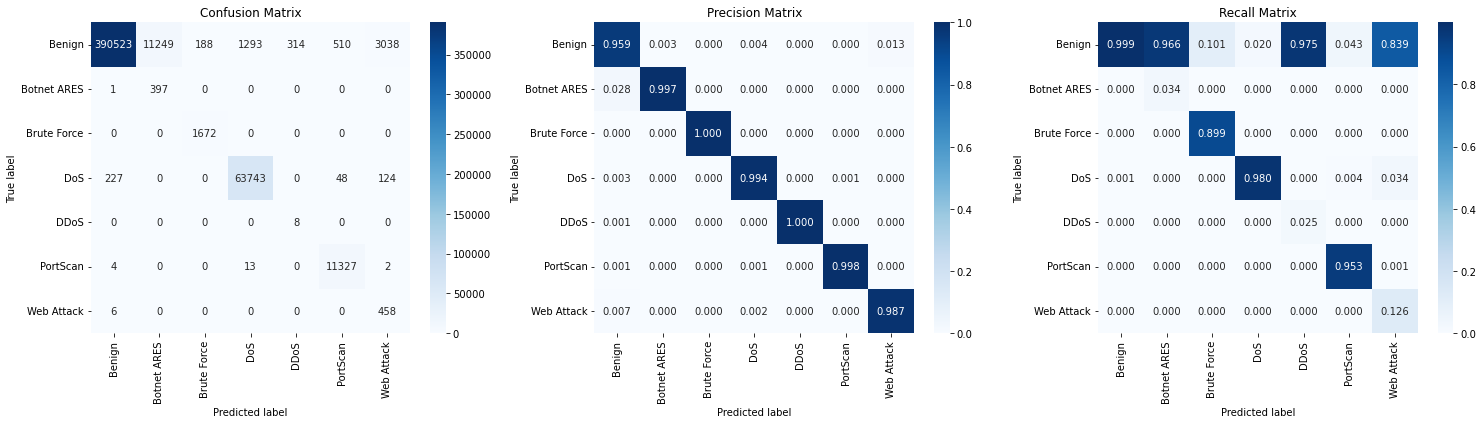

In [22]:
visualisation.plot_confusion_matrix(y_true=test_output_true,
                                    y_pred=test_output_pred,
                                    labels=labels,
                                    save=True,
                                    save_dir=IMAGE_DIR,
                                    filename="imb_cw_dbn_test_confusion_matrix.pdf")

In [23]:
print("Testing Set -- Classification Report", end="\n\n")
print(classification_report(test_output_true, test_output_pred, target_names=labels))

Testing Set -- Classification Report

              precision    recall  f1-score   support

      Benign       1.00      0.96      0.98    407115
 Botnet ARES       0.03      1.00      0.07       398
 Brute Force       0.90      1.00      0.95      1672
         DoS       0.98      0.99      0.99     64142
        DDoS       0.02      1.00      0.05         8
    PortScan       0.95      1.00      0.98     11346
  Web Attack       0.13      0.99      0.22       464

    accuracy                           0.96    485145
   macro avg       0.57      0.99      0.60    485145
weighted avg       0.99      0.96      0.98    485145



### Plot ROC curve

In [24]:
y_test = pd.get_dummies(test_output_true).values
y_score = np.array(test_output_pred_prob)

FileNotFoundError: [Errno 2] No such file or directory: '/home/yanh/coding/dbn-based-nids/images/imb_cw_dbn_roc_curve.pdf'

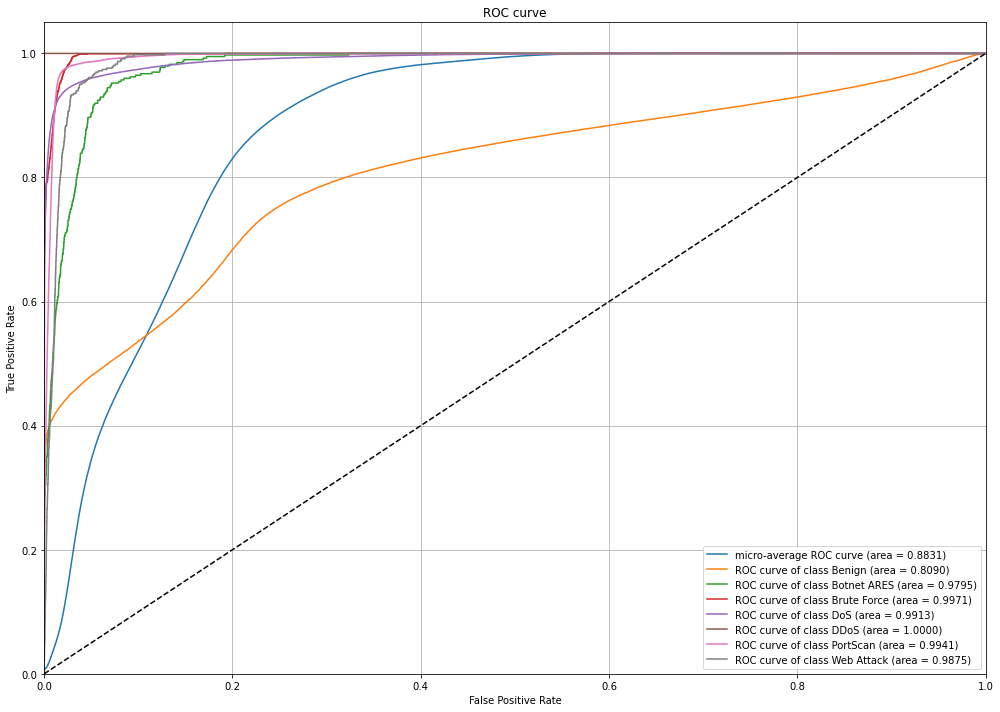

In [25]:
visualisation.plot_roc_curve(y_test=y_test,
                             y_score=y_score,
                             labels=labels,
                             save=True,
                             save_dir=IMAGE_DIR,
                             filename="imb_cw_dbn_roc_curve.pdf")

### Plot Precision vs. Recall curve

FileNotFoundError: [Errno 2] No such file or directory: '/home/yanh/coding/dbn-based-nids/images/imb_cw_dbn_prec_recall_curve.pdf'

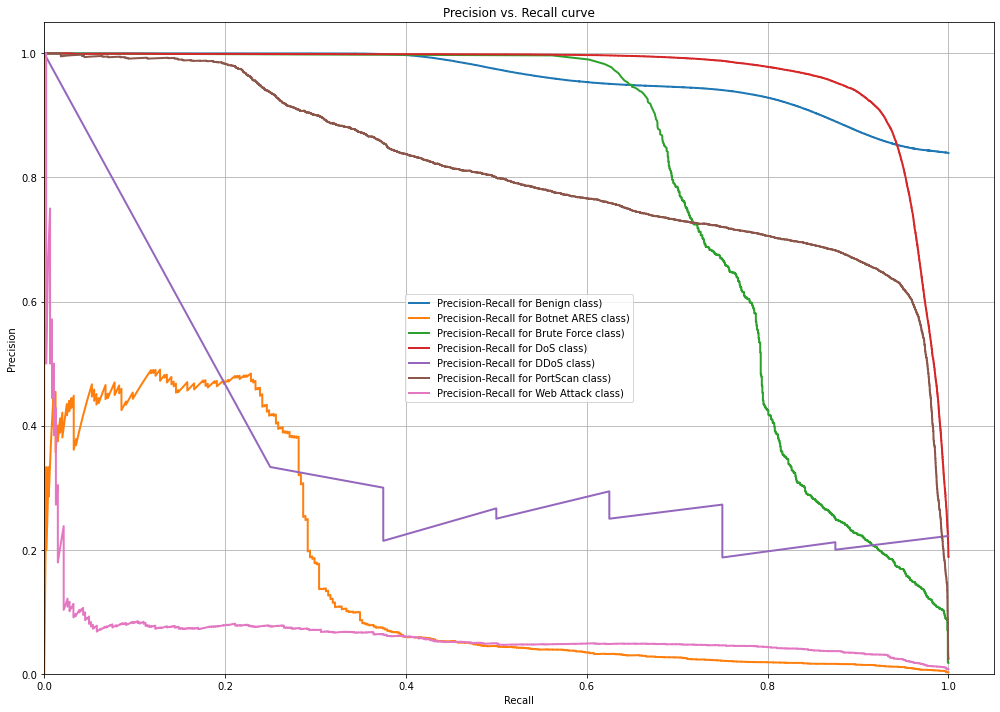

In [26]:
visualisation.plot_precision_recall_curve(y_test=y_test,
                                          y_score=y_score,
                                          labels=labels,
                                          save=True,
                                          save_dir=IMAGE_DIR,
                                          filename="imb_cw_dbn_prec_recall_curve.pdf")

### Save Model

In [ ]:
path = '../../checkpoints/imb_cw_deep_belief_network.pt'
torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            }, path)